### <center> Задание. Генерация признаков и оценка их важности

1. Необходимо выбрать датасет, с которым будете работать.
2. Построить базовую модель (baseline) с исходными признаками
3. Сгенерировать новые признаки и провести анализ важности признаков, поэкспериментировать с признаками, чтобы добиться улучшения качества модели. Результаты экспериментов описать в виде комеентариев
4. Поэкспериментировать с разными алгоритами (минимум 3), какой из алгоритмов покажет себя лучше всех. Результаты экспериментов описать в виде комеентариев
5. Подготовить презентацию результатов экспериментов (просто в виде ноутбука, делать презентацию в PowerPoint не нужно)     

2. Прогнозирование задержки рейса

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install eli5
import eli5
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.preprocessing import RobustScaler, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/My Drive/flight_delays.csv')
airports = pd.read_csv('drive/My Drive/airports.csv')
airlines = pd.read_csv('drive/My Drive/airlines.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#deptime - округлить до часов
#orig-dest - посмотреть на зависимость от задердек
#попытаться глянуть месяцы и дни

In [ ]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
df.shape

(100000, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [ ]:
for col in df.columns:
  print(df[col].unique())
  print(' - ')
  print(df[col].nunique())
  print('-' *75)

['c-8' 'c-4' 'c-9' 'c-11' 'c-10' 'c-1' 'c-7' 'c-6' 'c-5' 'c-3' 'c-12'
 'c-2']
 - 
12
---------------------------------------------------------------------------
['c-21' 'c-20' 'c-2' 'c-25' 'c-7' 'c-3' 'c-27' 'c-29' 'c-28' 'c-5' 'c-6'
 'c-10' 'c-19' 'c-26' 'c-14' 'c-22' 'c-9' 'c-31' 'c-4' 'c-16' 'c-18'
 'c-30' 'c-1' 'c-24' 'c-15' 'c-17' 'c-8' 'c-12' 'c-13' 'c-11' 'c-23']
 - 
31
---------------------------------------------------------------------------
['c-7' 'c-3' 'c-5' 'c-6' 'c-4' 'c-2' 'c-1']
 - 
7
---------------------------------------------------------------------------
[1934 1548 1422 ... 2530  219 2415]
 - 
1300
---------------------------------------------------------------------------
['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA']
 - 
22
---------------------------------------------------------------------------
['ATL' 'PIT' 'RDU' 'DEN' 'MDW' 'MEM' 'PBI' 'MSP' 'ONT' 'BDL' 'PHX' 'LAS'
 'DFW' 'DSM' 'CMH' 'ORF' 'SL

In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
airports['STATE'].nunique()

54

In [ ]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [ ]:
airlines['IATA_CODE'].unique()

array(['UA', 'AA', 'US', 'F9', 'B6', 'OO', 'AS', 'NK', 'WN', 'DL', 'EV',
       'HA', 'MQ', 'VX'], dtype=object)

Интересная ситуация: в основном датафрейме больше уникальных компаний-перевозчиков

In [ ]:
df['UniqueCarrier'].unique()

array(['AA', 'US', 'XE', 'OO', 'WN', 'NW', 'DL', 'OH', 'AS', 'UA', 'MQ',
       'CO', 'EV', 'DH', 'YV', 'F9', 'AQ', 'TZ', 'HP', 'B6', 'FL', 'HA'],
      dtype=object)

# Изначальный baseline

In [ ]:
dfcopy = df.copy()
dfcopy

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [ ]:
dfcopy['Month'].unique()

array(['c-8', 'c-4', 'c-9', 'c-11', 'c-10', 'c-1', 'c-7', 'c-6', 'c-5',
       'c-3', 'c-12', 'c-2'], dtype=object)

In [ ]:
month = {}
for i in range(1, len(dfcopy['Month'].unique())+1):
  month[f'c-{i}'] = i
print(month)
dfcopy['Month'] = dfcopy['Month'].map(month)
dfcopy

{'c-1': 1, 'c-2': 2, 'c-3': 3, 'c-4': 4, 'c-5': 5, 'c-6': 6, 'c-7': 7, 'c-8': 8, 'c-9': 9, 'c-10': 10, 'c-11': 11, 'c-12': 12}


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,4,c-20,c-3,1548,US,PIT,MCO,834,N
2,9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [ ]:
daysM = {}
for i in range(1, len(dfcopy['DayofMonth'].unique())+1):
  daysM[f'c-{i}'] = i
print(daysM)
dfcopy['DayofMonth'] = dfcopy['DayofMonth'].map(daysM)
dfcopy

{'c-1': 1, 'c-2': 2, 'c-3': 3, 'c-4': 4, 'c-5': 5, 'c-6': 6, 'c-7': 7, 'c-8': 8, 'c-9': 9, 'c-10': 10, 'c-11': 11, 'c-12': 12, 'c-13': 13, 'c-14': 14, 'c-15': 15, 'c-16': 16, 'c-17': 17, 'c-18': 18, 'c-19': 19, 'c-20': 20, 'c-21': 21, 'c-22': 22, 'c-23': 23, 'c-24': 24, 'c-25': 25, 'c-26': 26, 'c-27': 27, 'c-28': 28, 'c-29': 29, 'c-30': 30, 'c-31': 31}


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,c-7,1934,AA,ATL,DFW,732,N
1,4,20,c-3,1548,US,PIT,MCO,834,N
2,9,2,c-5,1422,XE,RDU,CLE,416,N
3,11,25,c-6,1015,OO,DEN,MEM,872,N
4,10,7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,4,c-3,1618,OO,SFO,RDD,199,N
99996,1,18,c-3,804,CO,EWR,DAB,884,N
99997,1,24,c-2,1901,NW,DTW,IAH,1076,N
99998,4,27,c-4,1515,MQ,DFW,GGG,140,N


In [ ]:
daysW = {}
for i in range(1, len(dfcopy['DayOfWeek'].unique())+1):
  daysW[f'c-{i}'] = i
print(daysW)
dfcopy['DayOfWeek'] = dfcopy['DayOfWeek'].map(daysW)
dfcopy

{'c-1': 1, 'c-2': 2, 'c-3': 3, 'c-4': 4, 'c-5': 5, 'c-6': 6, 'c-7': 7}


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,N
99996,1,18,3,804,CO,EWR,DAB,884,N
99997,1,24,2,1901,NW,DTW,IAH,1076,N
99998,4,27,4,1515,MQ,DFW,GGG,140,N


In [ ]:
def timeChanger(time: int):
  if time % 100 < 30:
    time = int((time - time % 100) / 100)
  else:
    time = int((time - time % 100) / 100) + 1
  if time >= 24:
    time = time % 24
  return time

# dfcopy['DepTime'] = dfcopy['DepTime'].apply(timeChanger)

In [ ]:
dfcopy['DepTime'].nunique()

1300

In [ ]:
dfcopy

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,N
99996,1,18,3,804,CO,EWR,DAB,884,N
99997,1,24,2,1901,NW,DTW,IAH,1076,N
99998,4,27,4,1515,MQ,DFW,GGG,140,N


In [ ]:
delayMapper = {'N': 0, 'Y': 1}
dfcopy['dep_delayed_15min'] = dfcopy['dep_delayed_15min'].map(delayMapper)
dfcopy

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,0
1,4,20,3,1548,US,PIT,MCO,834,0
2,9,2,5,1422,XE,RDU,CLE,416,0
3,11,25,6,1015,OO,DEN,MEM,872,0
4,10,7,6,1828,WN,MDW,OMA,423,1
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0
99996,1,18,3,804,CO,EWR,DAB,884,0
99997,1,24,2,1901,NW,DTW,IAH,1076,0
99998,4,27,4,1515,MQ,DFW,GGG,140,0


Качество, конечно, такое себе

In [ ]:
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1').mean()

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.052871006874241816
Точность на кросс-валидации: 
0.10739250481196201


Почти все признаки не оказывают положительного влияния на модель (distance даже ухудшает ее)

In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0255 ± 0.0015,DepTime
0 ± 0.0000,DayOfWeek
0 ± 0.0000,DayofMonth
0 ± 0.0000,Month
-0.0122 ± 0.0037,Distance


# Генерация новых признаков

Для начала можно округлить время

In [ ]:
dfcopy['DepTime'] = dfcopy['DepTime'].apply(timeChanger)

x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.13451080641412969
Точность на кросс-валидации: 
0.10815681847669892


При округлении времени качество модели немного улучшилось
> 
Немного странное поведение фичи: вред от distance уменьшился

In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0768 ± 0.0037,DepTime
0.0011 ± 0.0049,Distance
0 ± 0.0000,DayOfWeek
0 ± 0.0000,DayofMonth
0 ± 0.0000,Month


Как вариант, можно попробовать выделить праздничные дни (решил взять с 25 декабря по 8 января, с 8 по 10 мая и с 3 по 5 июля [День независимости в США])

In [ ]:
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  int64 
 1   DayofMonth         100000 non-null  int64 
 2   DayOfWeek          100000 non-null  int64 
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 6.9+ MB


In [ ]:
#думал черз index сделать, но там времени много на обработку уходило
ind = dfcopy[(((dfcopy['Month']==12) & (dfcopy['DayofMonth']>=25)) | ((dfcopy['Month']==1) & (dfcopy['DayofMonth']<=8)) | 
            ((dfcopy['Month']==5) & (dfcopy['DayofMonth']<=10) & (dfcopy['DayofMonth']>=8)) |
            ((dfcopy['Month']==7) & (dfcopy['DayofMonth']<=5) & (dfcopy['DayofMonth']>=3)))].index
ind

Int64Index([   24,    26,    31,    88,    92,    96,    97,   113,   134,
              140,
            ...
            99763, 99800, 99814, 99839, 99845, 99848, 99911, 99940, 99950,
            99974],
           dtype='int64', length=5534)

In [ ]:
dfcopy['isHoliday'] = 0
dfcopy.loc[(((dfcopy['Month']==12) & (dfcopy['DayofMonth']>=25)) | ((dfcopy['Month']==1) & (dfcopy['DayofMonth']<=8)) | 
            ((dfcopy['Month']==5) & (dfcopy['DayofMonth']<=10) & (dfcopy['DayofMonth']>=8)) |
            ((dfcopy['Month']==7) & (dfcopy['DayofMonth']<=5) & (dfcopy['DayofMonth']>=3))), 'isHoliday'] = 1
dfcopy.loc[20:26]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,isHoliday
20,8,22,2,15,AA,CLT,DFW,936,0,0
21,6,21,3,15,EV,ATL,ILM,377,1,0
22,11,26,6,14,DL,GSO,ATL,306,0,0
23,11,9,3,9,DH,IAD,CMH,299,0,0
24,12,31,6,19,DL,ATL,MSP,906,0,1
25,4,4,1,7,WN,SMF,PHX,647,0,0
26,7,3,7,14,AA,FLL,LGA,1076,0,1


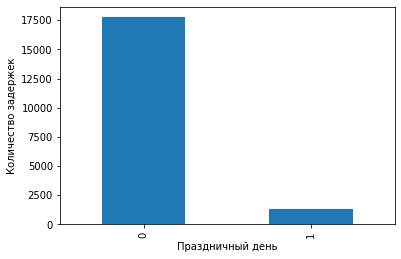

In [ ]:
#по графику можно понять, что в праздники люди не так уж часто летают, однако, зависимость проверить все равно стоит
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['isHoliday']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Праздничный день');
plt.ylabel('Количество задержек');

In [ ]:
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.13451080641412969
Точность на кросс-валидации: 
0.10815681847669892


Очень странно, что праздничный день не влияет на задержку рейса

In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0788 ± 0.0056,DepTime
0.0005 ± 0.0049,Distance
0 ± 0.0000,isHoliday
0 ± 0.0000,DayOfWeek
0 ± 0.0000,DayofMonth
0 ± 0.0000,Month


Зависимость задержки от компании
>
Как видно, некоторые компании практически не имеют задержек, потому имеет смысл построить модель с их участием

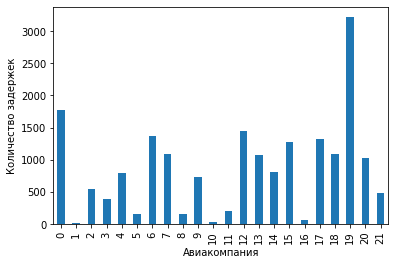

In [ ]:
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['UniqueCarrier']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Авиакомпания');
plt.ylabel('Количество задержек');

In [ ]:
carrierMapper = {dfcopy['UniqueCarrier'].unique()[i]: i for 
                 i in range(len(dfcopy['UniqueCarrier'].unique()))}
carrierMapper

{'AA': 0,
 'AQ': 16,
 'AS': 8,
 'B6': 19,
 'CO': 11,
 'DH': 13,
 'DL': 6,
 'EV': 12,
 'F9': 15,
 'FL': 20,
 'HA': 21,
 'HP': 18,
 'MQ': 10,
 'NW': 5,
 'OH': 7,
 'OO': 3,
 'TZ': 17,
 'UA': 9,
 'US': 1,
 'WN': 4,
 'XE': 2,
 'YV': 14}

Результаты по-прежнему не радуют

In [ ]:
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday', 'UniqueCarrier']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.13196549312193986
Точность на кросс-валидации: 
0.10595233324544581


То, что влияет на модель, не приносит пользы
>
Вполне вероятно, что дело в обработке категориальных признаков

In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0751 ± 0.0046,DepTime
0.0012 ± 0.0035,Distance
0 ± 0.0000,isHoliday
0 ± 0.0000,DayOfWeek
0 ± 0.0000,DayofMonth
0 ± 0.0000,Month
-0.0010 ± 0.0002,UniqueCarrier


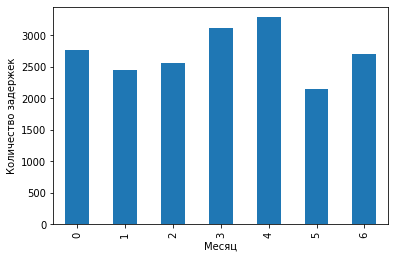

In [ ]:
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['DayOfWeek']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Месяц');
plt.ylabel('Количество задержек');

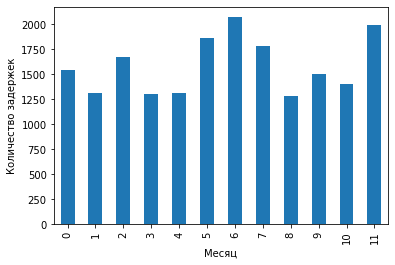

In [ ]:
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['Month']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Месяц');
plt.ylabel('Количество задержек');

Из графика по месяцам видно, что осенью идет просадка
>
Возможно, стоит обратить внимание на сезон

In [ ]:
dfcopy['season'] = 0
dfcopy.loc[((dfcopy['Month']==12) | (dfcopy['Month']<3)), 'season'] = 1
dfcopy.loc[((dfcopy['Month']>=3) & (dfcopy['Month']<6)), 'season'] = 2
dfcopy.loc[((dfcopy['Month']>=6) & (dfcopy['Month']<9)), 'season'] = 3
dfcopy.loc[((dfcopy['Month']>=9) & (dfcopy['Month']<12)), 'season'] = 4
dfcopy

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,isHoliday,season
0,8,21,7,20,0,ATL,DFW,732,0,0,3
1,4,20,3,16,1,PIT,MCO,834,0,0,2
2,9,2,5,14,2,RDU,CLE,416,0,0,4
3,11,25,6,10,3,DEN,MEM,872,0,0,4
4,10,7,6,18,4,MDW,OMA,423,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,16,3,SFO,RDD,199,0,0,2
99996,1,18,3,8,11,EWR,DAB,884,0,0,1
99997,1,24,2,19,5,DTW,IAH,1076,0,0,1
99998,4,27,4,15,10,DFW,GGG,140,0,0,2


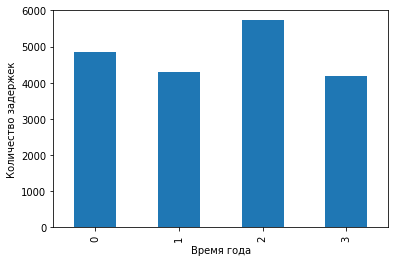

In [ ]:
#Лето и зима в лидерах, что не особо удивительно
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['season']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Время года');
plt.ylabel('Количество задержек');

In [ ]:
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday', 'UniqueCarrier', 'season']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.13196549312193986
Точность на кросс-валидации: 
0.10595233324544581


In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0753 ± 0.0050,DepTime
0.0002 ± 0.0045,Distance
0 ± 0.0000,season
0 ± 0.0000,isHoliday
0 ± 0.0000,DayOfWeek
0 ± 0.0000,DayofMonth
0 ± 0.0000,Month
-0.0011 ± 0.0004,UniqueCarrier


Убрав ненужные фичи, получаем интресный результат

In [ ]:
x = dfcopy[['DepTime']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.01512013256006628
Точность на кросс-валидации: 
0.014191412296765137


In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0099 ± 0.0013,DepTime


Вернем дистанцию

In [ ]:
x = dfcopy[['DepTime', 'Distance']]
y = dfcopy['dep_delayed_15min']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, random_state=17)
tree.fit(x, y)

scores = cross_val_score(tree, x, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(x), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.13451080641412969
Точность на кросс-валидации: 
0.10941821875464053


In [ ]:
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0765 ± 0.0047,DepTime
0.0011 ± 0.0039,Distance


Итог: после внесения возможных изменений качество модели возросло только при округлении времени

Можно рассмотреть зависимость задержек от пункта отправления

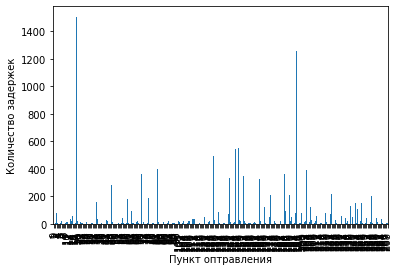

In [ ]:
#пусть и не понятно, но видно, что в некоторых местах задержки преобладают
gr = dfcopy[(dfcopy['dep_delayed_15min']==1)].groupby(['Origin']).sum().reset_index()
gr['dep_delayed_15min'].plot(kind='bar');
plt.xlabel('Пункт оптравления');
plt.ylabel('Количество задержек');

#Другие алгоритмы

In [ ]:
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday', 'UniqueCarrier', 'season']]
knn = KNeighborsClassifier()
knn.fit(x,y)
print(f1_score(knn.predict(x), y))
print(cross_val_score(knn, x, y, cv=kf, scoring="f1").mean())

0.38464422283871935
0.1766222084701674


In [ ]:
permutation = PermutationImportance(knn,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.2201 ± 0.0073,Distance
0.1690 ± 0.0062,DepTime
0.1425 ± 0.0068,DayofMonth
0.0991 ± 0.0077,UniqueCarrier
0.0652 ± 0.0061,Month
0.0162 ± 0.0017,DayOfWeek
0.0003 ± 0.0003,isHoliday
-0.0020 ± 0.0016,season


In [ ]:
x = dfcopy[['DepTime', 'Distance']]
knn = KNeighborsClassifier()
knn.fit(x,y)
print(f1_score(knn.predict(x), y))
print(cross_val_score(knn, x, y, cv=kf, scoring="f1").mean())

0.3650417026171987
0.23034974577774164


In [ ]:
permutation = PermutationImportance(knn,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.2136 ± 0.0054,DepTime
0.1596 ± 0.0021,Distance


In [ ]:
#scaler
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday', 'UniqueCarrier', 'season']]
scaler = RobustScaler()
features = scaler.fit_transform(x)

knn.fit(features,y)
print(f1_score(knn.predict(features), y))
print(cross_val_score(knn, X=features, y=y, cv=kf, scoring="f1").mean())

0.42408055725989824
0.23213704013741476


In [ ]:
permutation = PermutationImportance(knn,  scoring ='f1', n_iter=5, random_state=17).fit(features, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.2124 ± 0.0036,DepTime
0.1658 ± 0.0029,season
0.1536 ± 0.0044,UniqueCarrier
0.1488 ± 0.0047,DayofMonth
0.1451 ± 0.0060,Distance
0.1395 ± 0.0055,DayOfWeek
0.1143 ± 0.0036,Month
0.0253 ± 0.0014,isHoliday


In [ ]:
x = dfcopy[['DepTime', 'Distance']]
scaler = RobustScaler()
features = scaler.fit_transform(x)

knn.fit(features,y)
print(f1_score(knn.predict(features), y))
print(cross_val_score(knn, X=features, y=y, cv=kf, scoring="f1").mean())

0.3774236762321088
0.2511715150690258


In [ ]:
permutation = PermutationImportance(knn,  scoring ='f1', n_iter=5, random_state=17).fit(features, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.2219 ± 0.0056,DepTime
0.1525 ± 0.0082,Distance


In [ ]:
#NB
x = dfcopy[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'isHoliday', 'UniqueCarrier', 'season']]
nb = MultinomialNB()
nb.fit(x, y)
print(f1_score(nb.predict(x), y))
print(cross_val_score(knn, x, y, cv=kf, scoring="f1").mean())

0.30516753316435086
0.1766222084701674


In [ ]:
permutation = PermutationImportance(nb,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0650 ± 0.0020,DepTime
0.0028 ± 0.0012,DayofMonth
0.0020 ± 0.0004,UniqueCarrier
0.0006 ± 0.0012,Month
0.0006 ± 0.0006,isHoliday
0.0003 ± 0.0003,season
0.0002 ± 0.0004,DayOfWeek
-0.0063 ± 0.0035,Distance


In [ ]:
x = dfcopy[['DepTime', 'Distance']]
nb = MultinomialNB()
nb.fit(x, y)
print(f1_score(nb.predict(x), y))
print(cross_val_score(knn, x, y, cv=kf, scoring="f1").mean())

0.3027690700104493
0.23034974577774164


In [ ]:
permutation = PermutationImportance(nb,  scoring ='f1', n_iter=5, random_state=17).fit(x, y)
eli5.show_weights(permutation, feature_names=x.columns.tolist())

Weight,Feature
0.0908 ± 0.0052,DepTime
-0.0089 ± 0.0039,Distance


**В данной задаче дерево показало себя хуже остальных алгоритмов; генерация признаков не всегда нужна (в данной задаче они не сыграли роли, хотя не исключено, что они были заданы неправильно); очень часто наблюдалось переобучение; был еще вариант как-то использовать пункт отправления в важности признаков, но мне показалось, что делать так, как с компаниями-перевозчиками, будет неправильно**